# BLR transfer example

Welcome to this example/tutorial notebook that will go through the fitting and evaluation of BLR models. 

### Imports

In [1]:
import pandas as pd
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_blr import NormBLR
from pcntoolkit.regression_model.blr.blr_conf import BLRConf
from pcntoolkit.util.plotter import plot_centiles, plot_qq


# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [2]:
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)
data = pd.read_csv("resources/data/fcon1000.csv")
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=["age"],
    batch_effects=["sex", "site"],
    response_vars=["rh_MeanThickness_thickness", "WM-hypointensities"],
)

# Leave two sites out for doing transfer and extend later
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects(
    {"site": transfer_sites}, names=("transfer", "fit")
)

# Split into train and test sets
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. 

Our `NormConf` object configures:
- a save path paths and whether to save the model and results
- a standardization step for both the covariates (inscaler) and the response vars (outscaler)
- a Bspline basis expansion of order 3 with 5 knots

In [3]:
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir="resources/blr/save_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="bspline",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

Process: 52427 - Configuration of normative model is valid.


## Configure the regression model


In [4]:
blr_conf = BLRConf(
    optimizer="l-bfgs-b",
    n_iter=1000,
    heteroskedastic=True,
    random_intercept=True,
    random_intercept_var=True,
    warp="WarpSinhArcsinh",
    warp_reparam=True,
)

Configuration of regression model is valid.


## Combine normative and blr conf in normative model
We can either use the NormBLR constructor, or the factory method to create a normative BLR model

In [5]:
# Using the constructor
norm_blr = NormBLR(norm_conf=norm_conf, reg_conf=blr_conf)

In [6]:
# predictions = norm_blr.fit_predict(train, test)
norm_blr.fit(train)


Process: 52427 - Fitting models on 2 response variables.
Process: 52427 - Fitting model for rh_MeanThickness_thickness.
Process: 52427 - Fitting model for WM-hypointensities.
Process: 52427 - Saving model to resources/blr/save_dir.
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/model


In [7]:
norm_blr.predict(test)


Going to predict 2 models
Predicting model for rh_MeanThickness_thickness
Predicting model for WM-hypointensities
Computing logp for rh_MeanThickness_thickness
Computing logp for WM-hypointensities
Computing zscores for rh_MeanThickness_thickness
Computing zscores for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/plots


<xarray.NormData> Size: 86kB
Dimensions:            (datapoints: 186, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2, basis_functions: 7, cdf: 5,
                        measure: 8)
Coordinates:
  * datapoints         (datapoints) int64 1kB 515 441 1029 64 ... 640 648 635
  * covariates         (covariates) <U3 12B 'age'
  * response_vars      (response_vars) <U26 208B 'rh_MeanThickness_thickness'...
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * basis_functions    (basis_functions) <U13 364B 'age_bspline_0' ... 'age_b...
  * cdf                (cdf) float64 40B 0.05 0.25 0.5 0.75 0.95
  * measure            (measure) <U8 256B 'MSLL' 'NLL' ... 'SMSE' 'ShapiroW'
Data variables:
    X                  (datapoints, covariates) float64 1kB 18.0 20.0 ... 20.0
    y                  (datapoints, response_vars) float64 3kB 2.456 ... 460.3
    batch_effects      (datapoints, batch_effect_dims) <U17 25kB '0' ... 'ICBM'
    scaled_X           (datapoints, covariates) float64 1kB -0.7465 ... -0.5937
    scaled_y           (datapoints, response_vars) float64 3kB -0.2694 ... -0...
    Phi                (datapoints, basis_functions) float64 10kB 0.01205 ......
    logp               (datapoints, response_vars) float64 3kB -0.6917 ... -1...
    zscores            (datapoints, response_vars) float64 3kB -1.265 ... -1.944
    scaled_centiles    (cdf, datapoints, response_vars) float64 15kB -0.4067 ...
    centiles           (cdf, datapoints, response_vars) float64 15kB 2.443 .....
    Yhat               (datapoints, response_vars) float64 3kB 2.502 ... 948.5
    measures           (response_vars, measure) float64 128B -2.698 ... 0.9934
Attributes:
    name:                  fit_test
    unique_batch_effects:  {'sex': ['0', '1'], 'site': ['AnnArbor_a', 'AnnArb...
    batch_effects_counts:  {'sex': {'0': 493, '1': 437}, 'site': {'AnnArbor_a...

## Inspecting the model 

The norm_blr model contains a collection of regression models, one for each response variable. We can inspect those models individually by calling `norm_blr.regression_models.get("{responsevar}")`

In [8]:
model = norm_blr.regression_models.get("rh_MeanThickness_thickness")  # type: ignore
model.__dict__

{'_name': 'rh_MeanThickness_thickness',
 '_reg_conf': BLRConf(n_iter=1000, tol=1e-05, ard=False, optimizer='l-bfgs-b', l_bfgs_b_l=0.1, l_bfgs_b_epsilon=0.1, l_bfgs_b_norm='l2', intercept=False, random_intercept=True, heteroskedastic=True, intercept_var=False, random_intercept_var=True, warp='WarpSinhArcsinh', warp_reparam=True),
 'is_fitted': True,
 '_is_from_dict': False,
 'hyp': array([ 0.01619641,  0.57113467,  1.25436748,  0.7280543 ,  0.2021303 ,
        -0.02653259, -0.00958643,  1.02859025,  1.1100131 , -0.05368598,
         0.14570271,  0.1380715 , -0.03004053,  0.12214999,  0.05261086,
         0.38312616,  0.15350533, -0.06182822,  0.08558422,  0.24595732,
         0.19994398,  0.0688204 ,  0.63874647,  0.05624273,  0.17671639,
        -0.03516897, -0.18229828,  0.03151664, -0.04599766,  0.03321349,
        -0.22327915, -0.58718119, -0.05100935, -0.06679164,  0.02607679,
         0.01878657,  0.01004113, -0.10178388, -0.00655598,  0.02130646,
         0.0235664 ,  0.00353847,

## Evaluation
Calling `predict` will extend the predict_data object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [9]:
display(test.measures.to_pandas().T.round(3))


response_vars,rh_MeanThickness_thickness,WM-hypointensities
measure,,
MSLL,-2.698,6.951
NLL,1.758,0.977
R2,0.342,0.443
RMSE,0.077,516.267
Rho,0.551,0.565
Rho_p,0.000,0.000
SMSE,36.663,0.000
ShapiroW,0.986,0.993


Datasets with a zscores DataArray will have the `.plot_qq()` function available:

In [10]:
display(test.zscores.to_pandas())  # the zscores

response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
515,-1.264774,-0.382943
441,-0.669637,-0.689376
1029,1.587721,0.897206
64,-2.987887,0.459088
654,1.109020,-1.892350
...,...,...
611,-2.515169,2.239355
549,-1.814673,2.622223
640,-0.787399,-1.662289


In [11]:
display(test.centiles.to_dataframe().unstack(level=["response_vars", "cdf"]))

centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
515                             2.442583         879.423957   
441                             2.438153        1000.642727   
1029                            2.505207         613.722003   
64                              2.362176         573.058891   
654                             2.397053         629.748191   
...                                  ...                ...   
611                             2.415651         751.118017   
549                             2.257089         705.444345   
640                             2.345101         766.122157   
648                             2.432369         733.197282   
635                             2.525405         534.528413   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
515                             2.477365        1057.272495   
441                             2.470948        1177.849801   
1029                            2.548007         826.703188   
64                              2.404035         779.785355   
654                             2.444978         949.565880   
...                                  ...                ...   
611                             2.458994        1059.134771   
549                             2.330652         983.169036   
640                             2.407614        1135.163986   
648                             2.470025        1004.851993   
635                             2.567362         775.953531   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.50               0.50   
datapoints                                                    
515                             2.501580        1189.562348   
441                             2.493521        1313.094623   
1029                            2.581928         979.620997   
64                              2.430537         927.006685   
654                             2.476039        1191.430674   
...                                  ...                ...   
611                             2.487947        1300.254726   
549                             2.374857        1192.882315   
640                             2.445632        1441.954732   
648                             2.495841        1210.931812   
635                             2.600785         948.456722   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.75               0.75   
datapoints                                                    
515                             2.526939        1334.035877   
441                             2.516812        1464.587614   
1029                            2.620554        1141.502118   
64                              2.455585        1081.018304   
654                             2.507293        1478.254457   
...                                  ...                ...   
611                             2.517761        1597.433635   
549                             2.414198        1435.524048   
640                             2.481525        1868.861786   
648                             2.522704        1450.047371   
635                             2.638558        1131.249809   

                                                             
response_vars rh_MeanThickness_thickness WM-hypointensities  
cdf                                 0.95               0.95  
datapoints                                                   


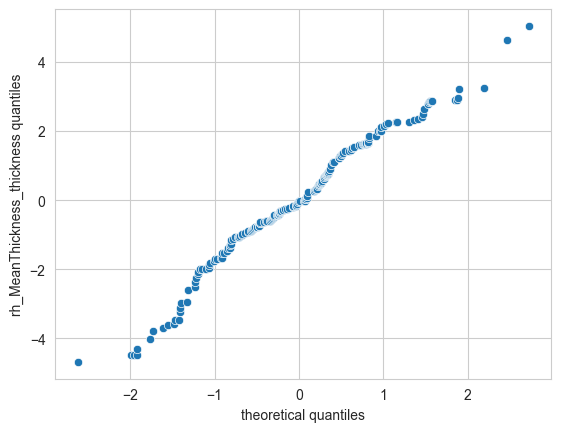

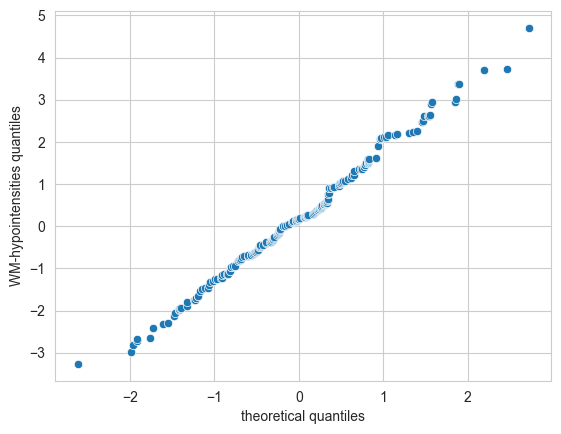

In [12]:
plot_qq(test)

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`train` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.25, 0.5, 0.75, 0.95]. It is also possible to pass a list of CDF values to plot.

It may seem strange that the centiles do not match the plotted data, but that is because the centiles are calculated for a single batch effect, and it is superimposed on the full dataset. The blue markers correspond to the data for which the centiles are calculated. 

Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


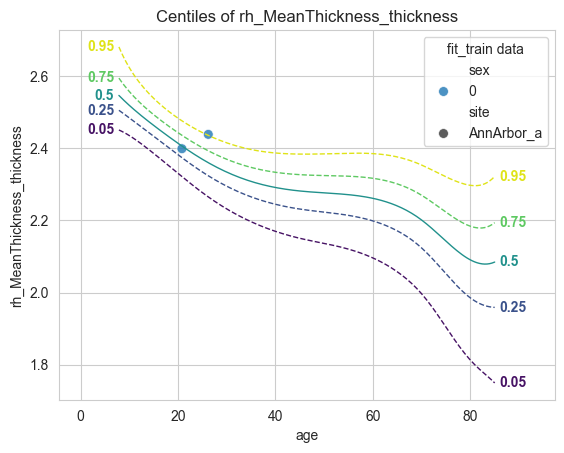

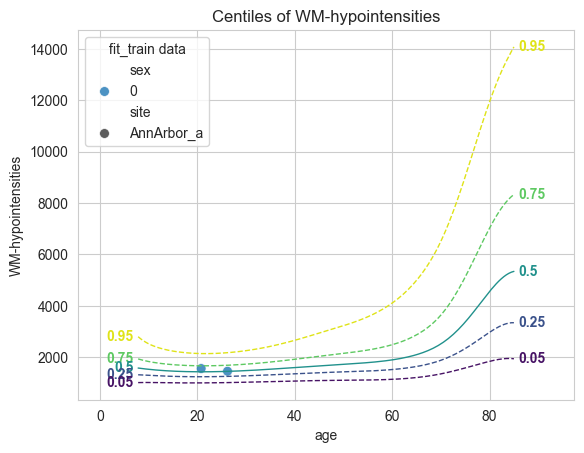

In [13]:
plot_centiles(
    norm_blr,
    train,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
)

The values of 0.1587 and 0.8413 correspond to a standard deviation of -1 and 1. We plot the centiles again for these values, and we also highlight a specific site. 


Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"]*len(non_be_df)


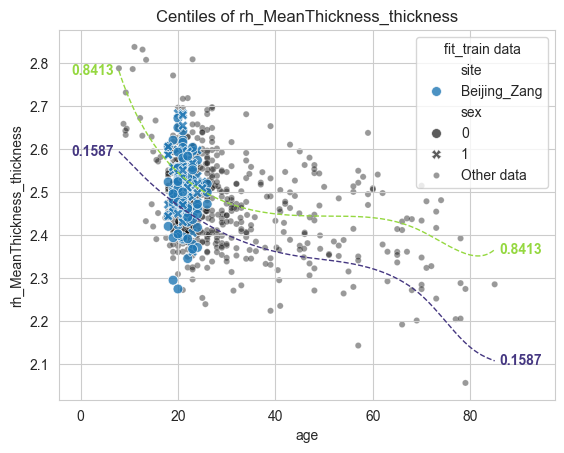

/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/plotter.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_be_df["marker"] = ["Other data"]*len(non_be_df)


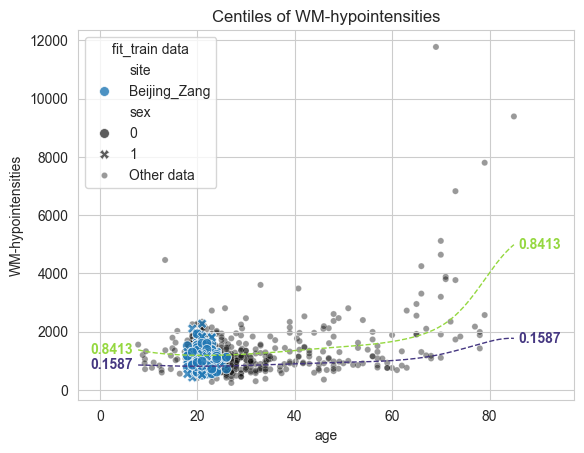

In [15]:
plot_centiles(
    norm_blr,
    train,
    covariate="age",
    cummul_densities=[0.1587, 0.8413],
    show_data=True,
    batch_effects={"site": ["Beijing_Zang"]},
    show_other_data=True,
)

And that's it, now you have seen how to:
- Use the NormData class to load in your data
- Create and fit a normative model
- Get the evaluation statistics, and create some useful plots

We hope this tutorial was useful. If you have any questions or remarks, please let us know on GitHub. Thanks!